<!-- Autogenerated by `scripts/make_examples.py` -->
<table align="left">
    <td>
        <a target="_blank" href="https://colab.research.google.com/github/voxel51/fiftyone-examples/blob/master/examples/convert_tags_to_classifications.ipynb">
            <img src="https://user-images.githubusercontent.com/25985824/104791629-6e618700-5769-11eb-857f-d176b37d2496.png" height="32" width="32">
            Try in Google Colab
        </a>
    </td>
    <td>
        <a target="_blank" href="https://nbviewer.jupyter.org/github/voxel51/fiftyone-examples/blob/master/examples/convert_tags_to_classifications.ipynb">
            <img src="https://user-images.githubusercontent.com/25985824/104791634-6efa1d80-5769-11eb-8a4c-71d6cb53ccf0.png" height="32" width="32">
            Share via nbviewer
        </a>
    </td>
    <td>
        <a target="_blank" href="https://github.com/voxel51/fiftyone-examples/blob/master/examples/convert_tags_to_classifications.ipynb">
            <img src="https://user-images.githubusercontent.com/25985824/104791633-6efa1d80-5769-11eb-8ee3-4b2123fe4b66.png" height="32" width="32">
            View on GitHub
        </a>
    </td>
    <td>
        <a href="https://github.com/voxel51/fiftyone-examples/raw/master/examples/convert_tags_to_classifications.ipynb" download>
            <img src="https://user-images.githubusercontent.com/25985824/104792428-60f9cc00-576c-11eb-95a4-5709d803023a.png" height="32" width="32">
            Download notebook
        </a>
    </td>
</table>


# Converting tags to classifications

When working in the FiftyOne App, you can interactively [create, delete, and modify tags](https://voxel51.com/docs/fiftyone/user_guide/app.html#tags-and-tagging) right from the browser. When working with [Classification](https://voxel51.com/docs/fiftyone/user_guide/using_datasets.html#classification) labels, it makes sense to want to be able to annotate these labels the same as tags from the App.

The primary distinction between [Classifications](https://voxel51.com/docs/fiftyone/user_guide/using_datasets.html#multilabel-classification) and [tags](https://voxel51.com/docs/fiftyone/user_guide/using_datasets.html#tags) is that Classifications can contain an arbitrary number of attributes associated with them, which is why it is generally recommended to use the [integrations with annotations tools like CVAT](https://voxel51.com/docs/fiftyone/integrations/cvat.html) to annotate these labels. Another benefit of using the [Classification](https://voxel51.com/docs/fiftyone/user_guide/using_datasets.html#classification) label type is that you can access the extensive [evaluation capabilities](https://voxel51.com/docs/fiftyone/user_guide/evaluation.html#classifications) of FiftyOne.

However, if you are only populating the `label` of Classifications, then it can make sense to treat them like tags. This example shows how to convert the `label` of Classifications to tags, modify them in the App, and then convert tags back to Classifications. 

Start by [installing FiftyOne](https://voxel51.com/docs/fiftyone/getting_started/install.html) if you haven't already:


In [ ]:
!pip install fiftyone

Then load an example dataset for this example.

In [1]:
import fiftyone as fo
import fiftyone.zoo as foz
from fiftyone import ViewField as F

dataset = foz.load_zoo_dataset("quickstart")

Dataset already downloaded
Loading 'quickstart'
 100% |█████████████████| 200/200 [3.6s elapsed, 0s remaining, 51.3 samples/s]      
Dataset 'quickstart' created


Since this dataset doesn't contain classifications, let's start by converting the existing tags to classifications. The idea here is to efficient load all tags into memory using the [values()](https://voxel51.com/docs/fiftyone/user_guide/using_aggregations.html#values) aggregation, then converting the tags to classification labels and setting them to a field on the dataset.

In [2]:
# Convert all tags to Classifications
def tags_to_classifications(dataset, classifications_field):
    tags = dataset.values("tags")
    classifications = []
    for sample_tags in dataset.values("tags"):
        cls = []
        if sample_tags:
            for tag in sample_tags:
                cls.append(fo.Classification(label=tag))
        classifications.append(fo.Classifications(classifications=cls))
        
    dataset.set_values(classifications_field, classifications)

Note: You could also optionally add some logic here to choose a specific tag (like the first in the list) and create a Classification field rather than Classifications.

In [3]:
field_name = "classifications"
tags_to_classifications(dataset, field_name)

Now let's launch the App and modify some tags. For example, we can change the tag of the first two samples from `validation` to `test`.


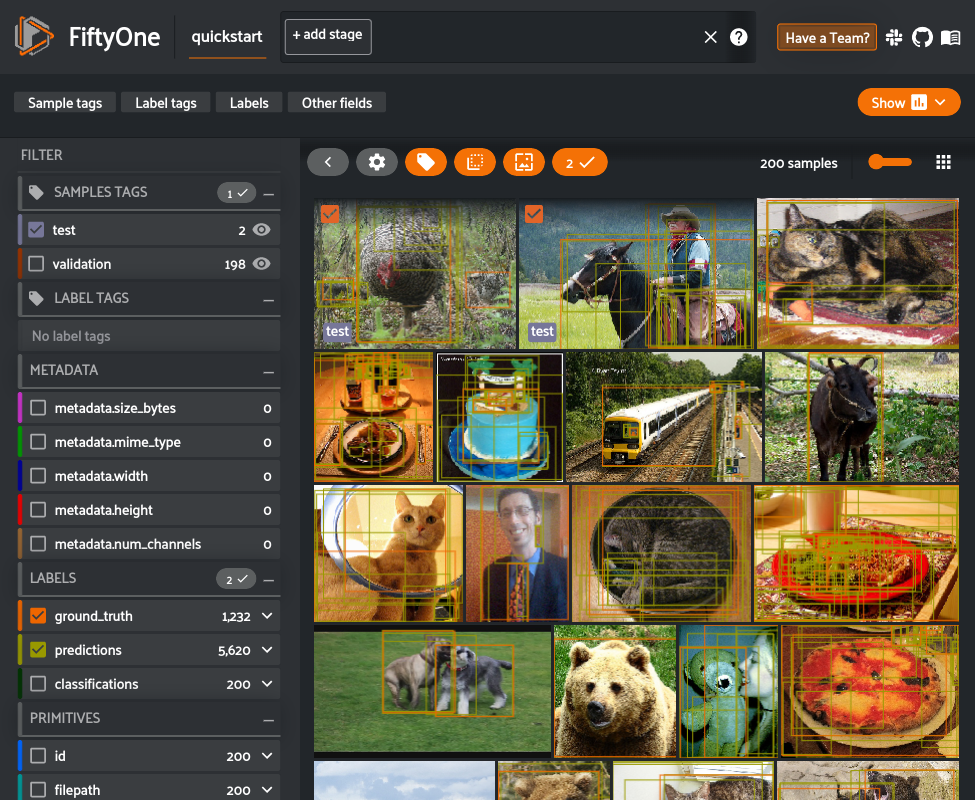

In [4]:
session = fo.launch_app(dataset)

In [5]:
session.freeze() # Screenshot the App for this example

Now we can convert the tags to classifications again to update them.

In [6]:
tags_to_classifications(dataset, field_name)

In [7]:
dataset.first()[field_name]

<Classifications: {
    'classifications': BaseList([
        <Classification: {
            'id': '629932460133108e479b4731',
            'tags': BaseList([]),
            'label': 'test',
            'confidence': None,
            'logits': None,
        }>,
    ]),
    'logits': None,
}>

As you can see, the classification labels have now been updated to match the tags.

Alternatively, we can also convert the existing classifications to tags. Since tags are simply a list of strings rather than FiftyOne Label objects, we can use a simple [ViewExpression]() to set tags.

In [18]:
# Convert Classifications to tags
def classifications_to_tags(dataset, classifications_field):
    if not dataset.has_sample_field(classifications_field):
        dataset.add_sample_field(
            classifications_field,
            fo.EmbeddedDocumentField,
            embedded_doc_type=fo.Classifications,
        )
    view = dataset.set_field("tags", F(classifications_field+".classifications.label"))
    view.save(fields="tags")

First, let's delete the existing tags on the dataset.

In [9]:
dataset

Name:        quickstart
Media type:  image
Num samples: 200
Persistent:  False
Tags:        ['test', 'validation']
Sample fields:
    id:              fiftyone.core.fields.ObjectIdField
    filepath:        fiftyone.core.fields.StringField
    tags:            fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:        fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth:    fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    uniqueness:      fiftyone.core.fields.FloatField
    predictions:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    classifications: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classifications)

In [11]:
dataset.untag_samples(dataset.distinct("tags"))

In [12]:
dataset

Name:        quickstart
Media type:  image
Num samples: 200
Persistent:  False
Tags:        []
Sample fields:
    id:              fiftyone.core.fields.ObjectIdField
    filepath:        fiftyone.core.fields.StringField
    tags:            fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:        fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth:    fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    uniqueness:      fiftyone.core.fields.FloatField
    predictions:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    classifications: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classifications)

Now to convert the classification to tags:

In [19]:
classifications_to_tags(dataset, field_name)

In [20]:
dataset

Name:        quickstart
Media type:  image
Num samples: 200
Persistent:  False
Tags:        ['test', 'validation']
Sample fields:
    id:              fiftyone.core.fields.ObjectIdField
    filepath:        fiftyone.core.fields.StringField
    tags:            fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:        fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth:    fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    uniqueness:      fiftyone.core.fields.FloatField
    predictions:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    classifications: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classifications)

As you can see, the dataset has the tags `test` and `validation` again.